In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

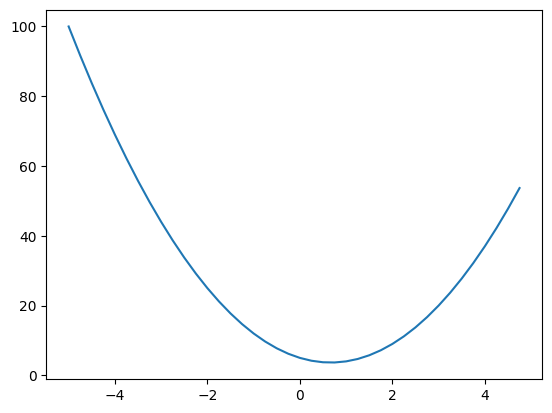

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [6]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [24]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad  # Need to accumulate the gradient
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [25]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [27]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

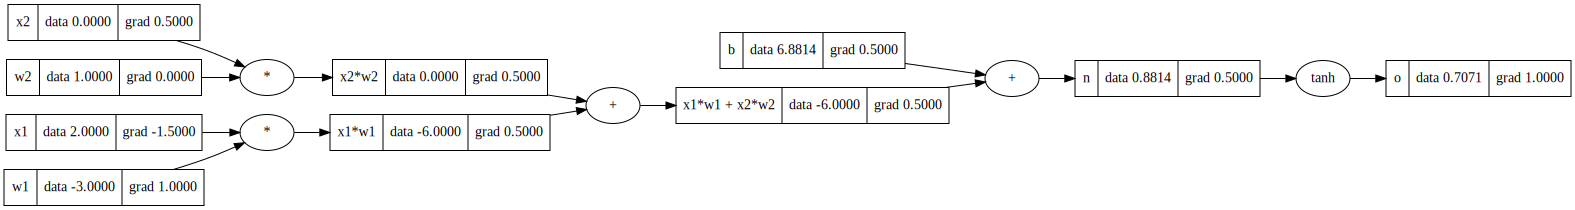

In [28]:
draw_dot(o)

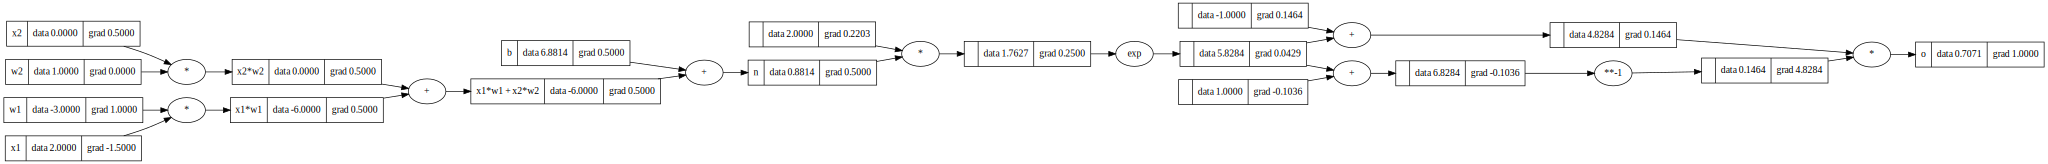

In [29]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [30]:
import torch

In [31]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

In [35]:
print(o.data.item())
o.backward()

0.7071066904050358


In [37]:
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [68]:
class Neuron:

  def __init__(self, nin):  # number of inputs
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]  # weights for each input, tanh range
    self.b = Value(random.uniform(-1,1))  # bias, only one, represents the overall trigger-happiness of this neuron

  def __call__(self, x):  # Call the object as though it was a function
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out  # Output of the neuron, through the tanh activation function

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):  # Number of outputs = number of neurons
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs  # activations of all the neurons in the layer

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):  # Number of outputs now a list, defines number of neurons per layer
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [153]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.8973317984542564)

In [154]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [155]:
ypred_history = []  # Store them so we can plot training progress

for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  ypred_history.append([yp.data for yp in ypred])
  # calculate MSE
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # y ground truth

  # backward pass
  for p in n.parameters():
    p.grad = 0.0  # need to do a zero-grad, which is necessary because we are accumulating grads at each pass
  loss.backward()

  # update
  for p in n.parameters():
    lr = 0.1
    p.data += -lr * p.grad

  print(f'{k:2}, {loss.data:.5f}, {[f"{yp.data:.3f}" for yp in ypred]}')

ypred_history_np = np.array(ypred_history).T

 0, 8.89026, ['-0.897', '0.255', '-0.127', '-0.718']
 1, 6.08742, ['-0.778', '-0.456', '-0.736', '-0.600']
 2, 3.27839, ['0.097', '0.153', '-0.392', '0.126']
 3, 2.90000, ['0.339', '0.307', '-0.474', '0.309']
 4, 2.61798, ['0.216', '0.071', '-0.682', '0.130']
 5, 2.34035, ['0.579', '0.332', '-0.646', '0.487']
 6, 2.16697, ['0.223', '-0.456', '-0.835', '-0.114']
 7, 2.96832, ['0.888', '0.663', '-0.579', '0.885']
 8, 0.71896, ['0.586', '-0.528', '-0.883', '0.442']
 9, 0.46195, ['0.797', '-0.420', '-0.867', '0.743']
10, 0.28627, ['0.746', '-0.712', '-0.906', '0.639']
11, 0.19711, ['0.827', '-0.679', '-0.900', '0.768']
12, 0.15648, ['0.837', '-0.730', '-0.908', '0.779']
13, 0.12986, ['0.852', '-0.756', '-0.913', '0.798']
14, 0.11061, ['0.863', '-0.776', '-0.917', '0.814']
15, 0.09610, ['0.873', '-0.792', '-0.920', '0.827']
16, 0.08480, ['0.880', '-0.805', '-0.923', '0.837']
17, 0.07578, ['0.887', '-0.816', '-0.926', '0.846']
18, 0.06841, ['0.893', '-0.826', '-0.928', '0.854']
19, 0.06229, 

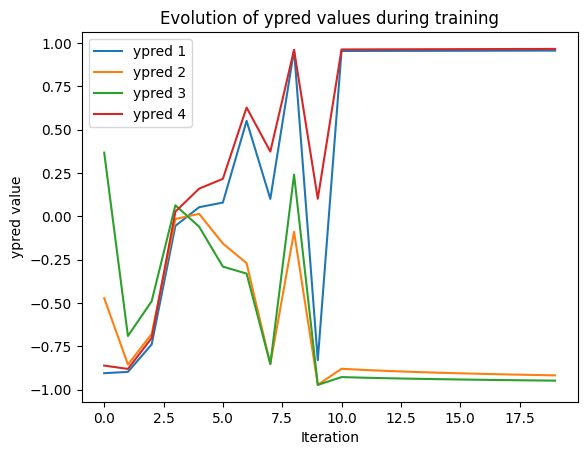

In [149]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for i in range(ypred_history_np.shape[0]):
    ax.plot(ypred_history_np[i], label=f'ypred {i+1}')

ax.set_title("Evolution of ypred values during training")
ax.set_xlabel("Iteration")
ax.set_ylabel("ypred value")
ax.legend()
plt.show()

In [94]:
# Select the first input example to trace
input_example = xs[0]
print(f"Tracing forward pass for input: {input_example}")

# Get the trained MLP object
model = n

# Start with the initial input
current_input = input_example

# Iterate through the layers
for i, layer in enumerate(model.layers):
    print(f"\n--- Layer {i+1} ---")
    # The output of the layer will be the input for the next layer
    layer_output = []

    # Iterate through the neurons in the current layer
    # Note: If the last layer has only one neuron, layer(x) returns a single Value object
    # If a layer has multiple neurons, layer(x) returns a list of Value objects
    # We need to handle this to iterate through neuron outputs
    if len(layer.neurons) == 1 and i == len(model.layers) - 1: # Handle the single output neuron case
        neuron = layer.neurons[0]
        print(f"  Neuron {1}:")
        # Calculate the weighted sum + bias manually for tracing
        weighted_sum_plus_bias = neuron.b
        for w, x_val in zip(neuron.w, current_input):
             weighted_sum_plus_bias += w * x_val

        print(f"    Input (from previous layer or initial): {[x.data if isinstance(x, Value) else x for x in current_input]}")
        print(f"    Weights: {[w.data for w in neuron.w]}")
        print(f"    Bias: {neuron.b.data}")
        print(f"    Weighted sum + bias (before tanh): {weighted_sum_plus_bias.data}")
        # Apply the activation function
        neuron_output = weighted_sum_plus_bias.tanh()
        print(f"    Output (after tanh): {neuron_output.data}")
        layer_output = [neuron_output] # Store as a list for consistency

    else: # Handle layers with multiple neurons
        for j, neuron in enumerate(layer.neurons):
            print(f"  Neuron {j+1}:")
            # Calculate the weighted sum + bias manually for tracing
            weighted_sum_plus_bias = neuron.b
            for w, x_val in zip(neuron.w, current_input):
                 # Need to handle x_val potentially being a Value object from previous layer
                 if isinstance(x_val, Value):
                     weighted_sum_plus_bias += w * x_val
                 else:
                     weighted_sum_plus_bias += w * Value(x_val) # Convert if not a Value

            print(f"    Input (from previous layer or initial): {[x.data if isinstance(x, Value) else x for x in current_input]}")
            print(f"    Weights: {[w.data for w in neuron.w]}")
            print(f"    Bias: {neuron.b.data}")
            print(f"    Weighted sum + bias (before tanh): {weighted_sum_plus_bias.data}")
            # Apply the activation function
            neuron_output = weighted_sum_plus_bias.tanh()
            print(f"    Output (after tanh): {neuron_output.data}")
            layer_output.append(neuron_output) # Collect outputs

    # The output of this layer becomes the input for the next
    current_input = layer_output

print("\n--- Final Output ---")
# The final output is the result of the last layer's computation
print(f"Final predicted value for {xs[0]}: {current_input[0].data if isinstance(current_input, list) else current_input.data}")

Tracing forward pass for input: [2.0, 3.0, -1.0]

--- Layer 1 ---
  Neuron 1:
    Input (from previous layer or initial): [2.0, 3.0, -1.0]
    Weights: [-0.26372706007651187, 0.38378742110980774, -0.7164873784303863]
    Bias: -0.08265796291863235
    Weighted sum + bias (before tanh): 1.2577375586881534
    Output (after tanh): 0.8504391752573164
  Neuron 2:
    Input (from previous layer or initial): [2.0, 3.0, -1.0]
    Weights: [0.35737749090538373, -0.5826350986970756, 0.7072012934011613]
    Bias: 0.16700688249500661
    Weighted sum + bias (before tanh): -1.5733447251866142
    Output (after tanh): -0.9175561571301014
  Neuron 3:
    Input (from previous layer or initial): [2.0, 3.0, -1.0]
    Weights: [0.413364837038247, 0.1964518835842334, 0.4727617546392538]
    Bias: -0.7036039949804123
    Weighted sum + bias (before tanh): 0.2397195752095282
    Output (after tanh): 0.2352308591295022
  Neuron 4:
    Input (from previous layer or initial): [2.0, 3.0, -1.0]
    Weights: [0.

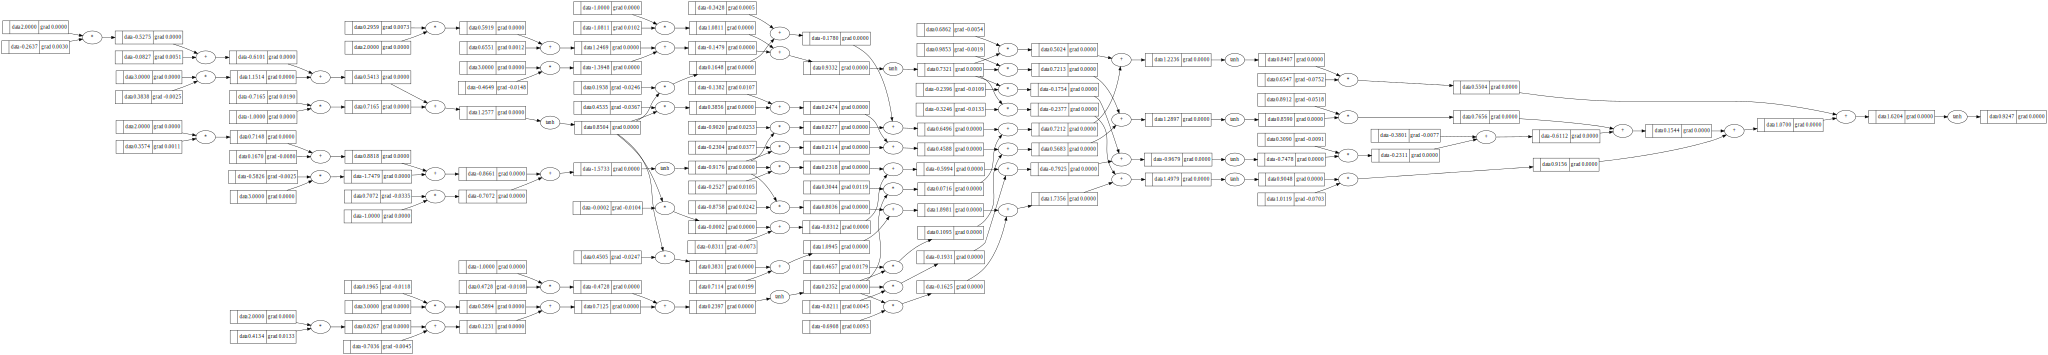

In [95]:
# Assuming the previous cell has been run and 'current_input' holds the final Value object
# The final output is likely in a list if the last layer had only one neuron
final_output_value = current_input[0] if isinstance(current_input, list) else current_input

# Draw the computation graph
draw_dot(final_output_value)